#**Udacity: Introduction to TensorFlow for Deep Learning**

## Lesson 5 Exercise

Build an image classfier to classifer flowers. Concepts applied   
- Using ImageDataGenerator class to perform data augmentation
- Applying dropout layer to create a more roboust model
- Using Early stopping to prevent model overfitting.

## **Import Dependencies**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import get_file

import os
import numpy as np
import matplotlib.pyplot as plt


In [2]:
print (tf.__version__)

2.5.0


## **Get the Data and Explore it**

Dataset contains different images of flowers. The flowers are within 5 different categories
1. Roses
2. Daisy
3. Dandelion
4. Sunflowers
5. Tulips


In [3]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
zip_file = get_file(origin=_URL,
                    fname="flower_photos.tgz",
                    extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'flower_photos')

print(base_dir)

228818944/228813984 [==============================] - 1s 0us/step
/root/.keras/datasets/flower_photos


In [4]:
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy


In [5]:
import glob # https://docs.python.org/3/library/glob.html
import shutil # https://docs.python.org/3/library/shutil.html

# error due to the names
#classes = ['Roses', 'Daisy', 'Dandelion', 'Sunflowers', 'Tulips']
classes = ['sunflowers', 'roses', 'daisy', 'dandelion', 'tulips']


for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  train, val = images[:round(len(images)*0.8)], images[round(len(images)*0.8):]


  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))
  

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

sunflowers: 699 Images
roses: 641 Images
daisy: 633 Images
dandelion: 898 Images
tulips: 799 Images


In [6]:
!find $base_dir -type d -print

/root/.keras/datasets/flower_photos
/root/.keras/datasets/flower_photos/train
/root/.keras/datasets/flower_photos/train/sunflowers
/root/.keras/datasets/flower_photos/train/dandelion
/root/.keras/datasets/flower_photos/train/roses
/root/.keras/datasets/flower_photos/train/tulips
/root/.keras/datasets/flower_photos/train/daisy
/root/.keras/datasets/flower_photos/sunflowers
/root/.keras/datasets/flower_photos/dandelion
/root/.keras/datasets/flower_photos/val
/root/.keras/datasets/flower_photos/val/sunflowers
/root/.keras/datasets/flower_photos/val/dandelion
/root/.keras/datasets/flower_photos/val/roses
/root/.keras/datasets/flower_photos/val/tulips
/root/.keras/datasets/flower_photos/val/daisy
/root/.keras/datasets/flower_photos/roses
/root/.keras/datasets/flower_photos/tulips
/root/.keras/datasets/flower_photos/daisy


In [7]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [8]:
for flower_class in classes:
  flower_class_train_dir = os.path.join(train_dir, flower_class)
  if os.path.exists(flower_class_train_dir):
    flower_class_train_dir_size = len([name for name in os.listdir(flower_class_train_dir) if os.path.isfile(os.path.join(flower_class_train_dir, name))])
    print('Flower class: {} and train size: {}'.format(flower_class, flower_class_train_dir_size))

  flower_class_val_dir = os.path.join(val_dir, flower_class)
  if os.path.exists(flower_class_val_dir):
    flower_class_val_dir_size = len([name for name in os.listdir(flower_class_val_dir) if os.path.isfile(os.path.join(flower_class_val_dir, name))])
    print('Flower class: {} and val size: {}'.format(flower_class, flower_class_val_dir_size))

Flower class: sunflowers and train size: 559
Flower class: sunflowers and val size: 140
Flower class: roses and train size: 513
Flower class: roses and val size: 128
Flower class: daisy and train size: 506
Flower class: daisy and val size: 127
Flower class: dandelion and train size: 718
Flower class: dandelion and val size: 180
Flower class: tulips and train size: 639
Flower class: tulips and val size: 160


## **Perform Data Augmentation**

It would be so easy to simply write a different image augmentation to apply to the dataset and then jump straight to model training.   
BUT   
As tedious as it is, i think it would be best to learn how to apply the different image transformation and at least view the outcome of it

In [9]:
batch_size = 42
IMG_SHAPE = 150

In [10]:
# function to plot the images
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 5, figsize=(20,20))
  axes = axes.flatten() # why flatten the axes?
  for img, ax in zip(images_arr, axes):
    ax.imshow(img)
  plt.tight_layout()
  plt.show()

### **1. Image Augmentation: Apply Random Horizontal Flip** 

In [11]:
random_horizontal_flip = ImageDataGenerator(rescale=1./255,
                                            horizontal_flip=True)

img_augmentation_1 = random_horizontal_flip.flow_from_directory(directory=train_dir,
                                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                )

Found 2935 images belonging to 5 classes.


70
(42, 150, 150, 3)


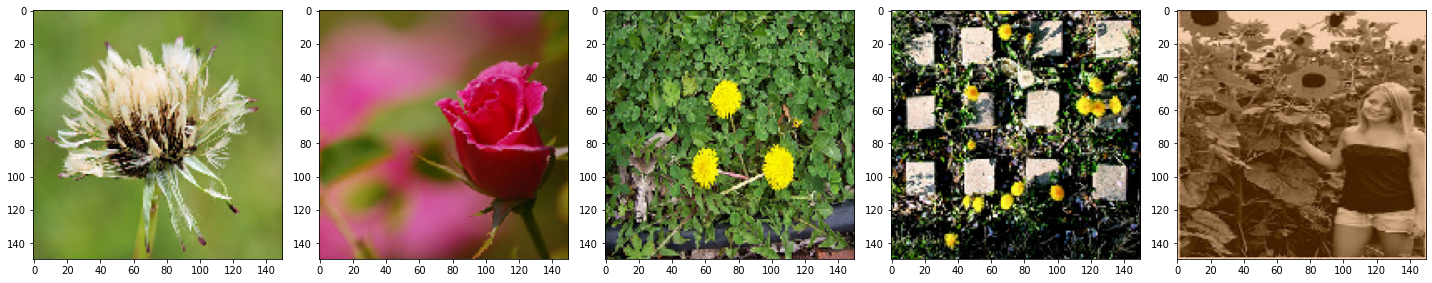

In [12]:
print(len(img_augmentation_1))

img_augmentation_1_item, _ = next(img_augmentation_1)
print(img_augmentation_1_item.shape)

img_to_plot = [img_augmentation_1_item[i] for i in range(5)]
plotImages(img_to_plot)

### **2. Image Augmentation: Apply Random Rotation**


In [13]:
random_rotation = ImageDataGenerator(rescale=1./255,
                                     rotation_range=45)

img_augmentation_2 = random_rotation.flow_from_directory(directory=train_dir,
                                                         target_size=(IMG_SHAPE, IMG_SHAPE),
                                                         batch_size=batch_size,
                                                         shuffle=True)

Found 2935 images belonging to 5 classes.


70
(42, 150, 150, 3)


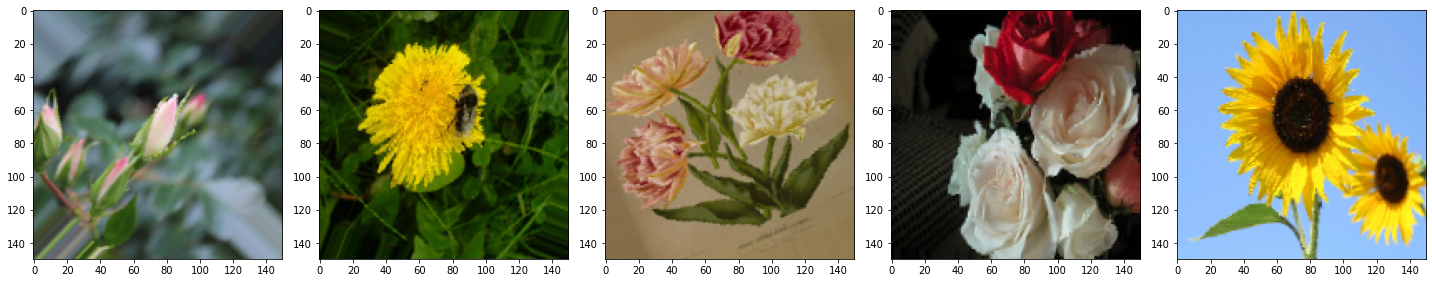

In [14]:
print(len(img_augmentation_2))

img_augmentation_2_item, _ = next(img_augmentation_2)
print(img_augmentation_2_item.shape)

img2_to_plot = [img_augmentation_2_item[i] for i in range(5)]
plotImages(img2_to_plot)

### **3. Image Augmentation: Apply Random Zoom**

In [15]:
random_zoom = ImageDataGenerator(rescale=1./255,
                                 zoom_range=[0.5, 1.5])

img_augmentation_3 = random_zoom.flow_from_directory(directory=train_dir,
                                                     target_size=(IMG_SHAPE, IMG_SHAPE),
                                                     batch_size=batch_size,
                                                     shuffle=True)

Found 2935 images belonging to 5 classes.


70
(42, 150, 150, 3)


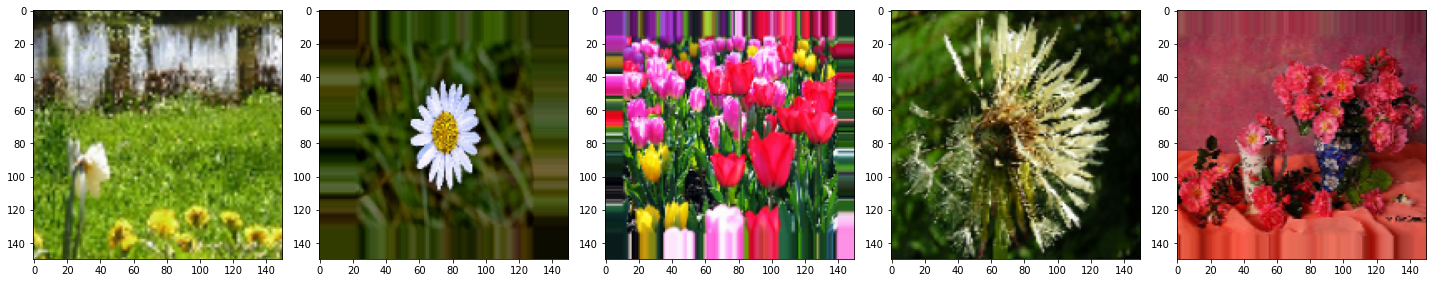

In [16]:
print(len(img_augmentation_3))

img_augmentation_3_item, _ = next(img_augmentation_3)
print(img_augmentation_3_item.shape)

img3_to_plot = [img_augmentation_3_item[i] for i in range(5)]
plotImages(img3_to_plot)

Some observation: There is some distortion that is added to the image due to the data augmentation. What is the impact of this?

### **4. Compile different image augmentation**

In [17]:
# putting all the different data augmentations together

complete_train_data_aug_gen = ImageDataGenerator(rescale=1./255,
                                             rotation_range=45,
                                             zoom_range=[0.5, 1.5],
                                             horizontal_flip=True,
                                             height_shift_range=0.15,
                                             width_shift_range=0.15
                                             )

Augmented_train_data = complete_train_data_aug_gen.flow_from_directory(directory=train_dir,
                                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                                   batch_size=batch_size,
                                                                   shuffle=True,
                                                                   class_mode='sparse')

Found 2935 images belonging to 5 classes.


In [18]:
val_data_gen = ImageDataGenerator(rescale=1./255)

Val_data = val_data_gen.flow_from_directory(directory=val_dir,
                                            target_size=(IMG_SHAPE, IMG_SHAPE),
                                            batch_size=batch_size,
                                            class_mode='sparse'
                                            )


Found 735 images belonging to 5 classes.


70
(42, 150, 150, 3)


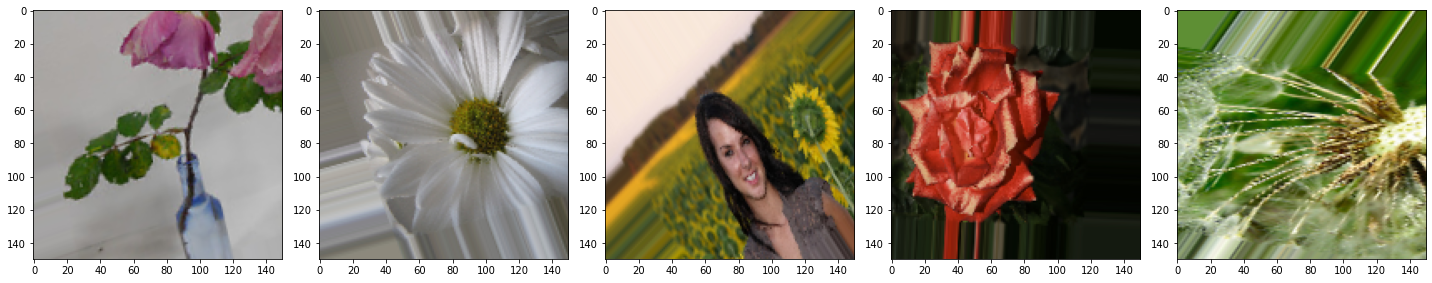

In [19]:
# print some of the data in final augmented training set

print(len(Augmented_train_data))

augmented_train_data_item, _ = next(Augmented_train_data)
print(augmented_train_data_item.shape)

aug_train_data_to_plot = [augmented_train_data_item[i] for i in range(5)]
plotImages(aug_train_data_to_plot)

## **Define a model and train it**

Model would be a 
- convolutional neural network, with 3 convolutional blocks
- 16 filters, 32 filters and 64 filters
- with a 3x3 kernel size and a 2,2 window for the pooling layer

In [20]:
cnn_model = tf.keras.Sequential()

# Add feature learning layers
cnn_model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
cnn_model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
cnn_model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))

# Add classification layer
cnn_model.add(tf.keras.layers.Dropout(rate=0.2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(units=512, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(units=5, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

cnn_model.summary

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fefc286ac10>>

In [21]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 17, 17, 64)        0

In [22]:
# train the model

# define number of epochs
EPOCHS = 100

# define callbacks (functions called at the end of each epoch)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)

history = cnn_model.fit(Augmented_train_data,
                        epochs=EPOCHS,
                        validation_data=Val_data,
                        callbacks=[early_stopping]
                        )

Epoch 1/100
70/70 [==============================] - 54s 326ms/step - loss: 1.3103 - accuracy: 0.4344 - val_loss: 1.1835 - val_accuracy: 0.5102
Epoch 2/100
70/70 [==============================] - 22s 321ms/step - loss: 1.0891 - accuracy: 0.5673 - val_loss: 1.1046 - val_accuracy: 0.5769
Epoch 3/100
70/70 [==============================] - 22s 320ms/step - loss: 0.9789 - accuracy: 0.6170 - val_loss: 0.9852 - val_accuracy: 0.6095
Epoch 4/100
70/70 [==============================] - 22s 320ms/step - loss: 0.9378 - accuracy: 0.6330 - val_loss: 0.9485 - val_accuracy: 0.6354
Epoch 5/100
70/70 [==============================] - 22s 321ms/step - loss: 0.9148 - accuracy: 0.6344 - val_loss: 0.8752 - val_accuracy: 0.6667
Epoch 6/100
70/70 [==============================] - 23s 322ms/step - loss: 0.8390 - accuracy: 0.6750 - val_loss: 0.8046 - val_accuracy: 0.6993
Epoch 7/100
70/70 [==============================] - 22s 320ms/step - loss: 0.8223 - accuracy: 0.6825 - val_loss: 0.7554 - val_accuracy:

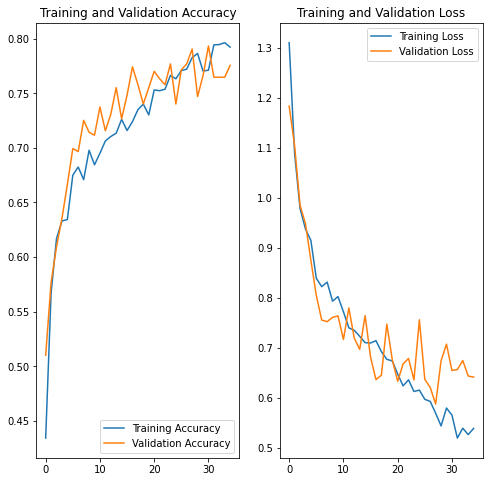

In [23]:
def plot_and_save_model_training_history(history, fig_name):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  plt.figure(figsize=(8,8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.savefig('./{}.png'.format(fig_name))
  plt.show()


plot_and_save_model_training_history(history, 'Model1')